<div style="background-color: RGB(51,165,182);" >
<h2 style="margin: auto; padding: 20px; color:#fff; ">Projet 12 - Détectez de faux billets avec Python</h2>
</div>

L’agence européenne EMV (European Monetary Verification), en charge du faux monnayage, nous a recommandé de commencer à tester 4 algorithmes :

- K-means
- Régression logistique
- KNN
- Random Forest

<div style="background-color: RGB(51,165,182);" >
<h2 style="margin: auto; padding: 20px; color:#fff; ">Etape 1 - Import et chargement</h2>
</div>

<div style="border: 1px solid RGB(51,165,182);" >
<h3 style="margin: auto; padding: 20px; color: RGB(51,165,182); ">1.1 - Importation des librairies</h3>
</div>

In [5]:
#Importation de la librairie Pandas
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as st
import datetime as dt

#Importation de la librairie plotly express
import plotly.express as px

#Chargement des librairies graphiques
sns.set()

#Librairies régressions
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
import statsmodels.formula.api as smf
import statsmodels.api as sm  # nécessaire aussi pour anova_lm
import scipy.stats as stats
from statsmodels.stats.stattools import durbin_watson
from statsmodels.stats.outliers_influence import variance_inflation_factor

#Librairie régressions
from sklearn.metrics import classification_report, accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn import preprocessing
from sklearn import metrics
from sklearn.metrics import ConfusionMatrixDisplay
from scipy.stats import mode
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from statsmodels.stats.stattools import durbin_watson
from statsmodels.stats.outliers_influence import variance_inflation_factor

#Librairie régression logistique
from sklearn.linear_model import LogisticRegression

#Librairie k-means
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from scipy.stats import mode

#Librairies KNN et Random Forest
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score

<div style="border: 1px solid RGB(51,165,182);" >
<h3 style="margin: auto; padding: 20px; color: RGB(51,165,182); ">1.2 - Chargement des fichiers</h3>
</div>

In [7]:
#Importation du fichier
df_billets = pd.read_csv('billets_final.csv', sep=',')
df_billets.head()

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length
0,True,171.81,104.86,104.95,4.52,2.89,112.83
1,True,171.46,103.36,103.66,3.77,2.99,113.09
2,True,172.69,104.48,103.50,4.40,2.94,113.16
3,True,171.36,103.91,103.94,3.62,3.01,113.51
4,True,171.73,104.28,103.46,4.04,3.48,112.54


<div style="background-color: RGB(51,165,182);" >
<h2 style="margin: auto; padding: 20px; color:#fff; ">Etape 2 - Prédiction du type du billet : K-means (classification non supervisée)</h2>
</div>

1/ DONNEES STANDARDISEES :

In [10]:
#Séparation des variables d’entrée et variable cible
X = df_billets.drop(columns=['is_genuine'])       #Variables d'entrée (toutes les colonnes de dimensions)
Y = df_billets['is_genuine']                      #Variable cible (vrai ou faux billet)

#Scindons le dataset en une partie entraînement (80%) + une partie test (20%)
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.20, random_state=42)  #Random state : même séparation effectuée à chaque exécution du code (n'importe quel entier fait l'affaire)

In [11]:
#Transformation en dataframe
X_train_df = pd.DataFrame(X_train).reset_index(drop=True)
y_train_df = pd.DataFrame(y_train).reset_index(drop=True)
X_test_df = pd.DataFrame(X_test).reset_index(drop=True)
y_test_df = pd.DataFrame(y_test).reset_index(drop=True)

In [12]:
#Standardisation des données (X_train)   
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)                                #Scaling - instancie/entraîne & transforme
pd.DataFrame(X_train_scaled).describe().round(2).iloc[1:3:, : ]               #Vérification moyenne = 0 et écart-type = 1

#Standardisation des données (X_test)
X_test_scaled = scaler.transform(X_test)                                     
pd.DataFrame(X_test_scaled).describe().round(2).iloc[1:3:, : ]               #Vérification moyenne = 0 et écart-type = 1

,0,1,2,3,4,5
mean,0.02,-0.01,0.01,0.08,0.01,-0.07
std,0.96,0.97,0.99,1.01,1.00,0.96


In [13]:
#Transformation en dataframe
X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=X.columns)
X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=X.columns)

In [14]:
#Création dataframe d'entraînement
df_train_scaled = pd.merge(y_train_df, X_train_scaled_df, left_index=True, right_index=True)
df_train_scaled.head(3)

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length
0,True,1.050853,1.958416,-0.367712,-0.597276,-0.306118,0.648529
1,True,-0.185700,1.559864,-1.317963,-0.597276,-1.428167,0.921625
2,False,-1.064303,0.995247,2.115204,0.618889,0.859087,-0.603164


In [15]:
#Création dataframe de test
df_test_scaled = pd.merge(y_test_df, X_test_scaled_df, left_index=True, right_index=True)
df_test_scaled.head(3)

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length
0,False,0.985771,-0.432900,0.613193,0.786112,1.161177,-1.615898
1,False,-0.999222,0.962034,1.410179,1.789448,0.384374,-0.443858
2,True,-1.389712,-1.661771,-0.888817,-0.658084,-0.823987,0.079577


In [16]:
#Détermination du nombre de clusters à retenir

# Définition d'une liste vide pour enregistrer les inerties :   
inertia_list_scaled = [ ]

# Liste de nombres de clusters qu'on veut tester : 
k_list_scaled = range(1, 10)

# Pour chaque nombre de clusters : 
for k in k_list_scaled : 
    
    # On instancie un k-means pour k clusters
    kmeans = KMeans(n_clusters=k)
    
     # On entraine le modèle K-Means sur les données du dataset
    kmeans.fit(X_train_scaled_df)
    
    # On enregistre l'inertie obtenue (=mesure à quel point les points sont proches de leur centroïde dans chaque cluster) : 
    inertia_list_scaled.append(kmeans.inertia_)

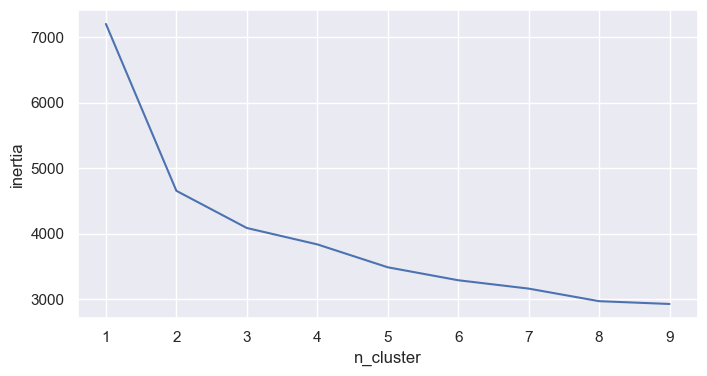

In [17]:
#Affichage courbe des inerties pour repérer le "coude" (constatation de la cassure)
fig, ax = plt.subplots(1,1,figsize=(8,4))

ax.set_ylabel("inertia")               # x = nb de clusters
ax.set_xlabel("n_cluster")             # y = valeur de l'inertie intraclasse
ax = plt.plot(k_list_scaled, inertia_list_scaled)

Interprétation selon la "méthode du coude" : 
- 1ere cassure la plus forte se situe à partir de 2 clusters
- Une 2nde cassure moins forte située à 5 clusters
- On devrait partir sur un total de 5 clusters mais cela n'a pas de sens car on souhaite prédire si un billet est vrai ou faux : logiquement on devrait donc avoir 2 clusters (1 cluster = vrais billets ; 2e cluster = faux billets). On retiendra donc 2 clusters in fine.

In [19]:
#Application de l'algorithme du K-Means
k_means_scaled = KMeans(n_clusters=2, random_state = 808)
k_means_scaled.fit(X_train_scaled_df)

#Libellés clusters
labels_kmeans_scaled = k_means_scaled.labels_
#Centroïdes
centroids_kmeans_scaled = k_means_scaled.cluster_centers_

In [20]:
#Ajout de la colonne avec le n° de cluster issu du k-means
df_train_scaled['cluster_kmeans'] = labels_kmeans_scaled
df_train_scaled.head(3)

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length,cluster_kmeans
0,True,1.050853,1.958416,-0.367712,-0.597276,-0.306118,0.648529,0
1,True,-0.185700,1.559864,-1.317963,-0.597276,-1.428167,0.921625,0
2,False,-1.064303,0.995247,2.115204,0.618889,0.859087,-0.603164,1


In [21]:
# Pour chaque cluster, nombre de vrais/faux billets
df_train_scaled_countbycluster_kmeans = df_train_scaled.groupby(['cluster_kmeans','is_genuine'])['diagonal'].count().reset_index(name='count')
print('Nombre de vrais/faux billets par cluster :')
df_train_scaled_countbycluster_kmeans

Nombre de vrais/faux billets par cluster :


,cluster_kmeans,is_genuine,count
0,0,False,13
1,0,True,804
2,1,False,377
3,1,True,6


In [22]:
# Attribuer un vrai/faux à chaque cluster du "df_train" (on retient le nombre max entre vrai et faux billet par cluster)

df_train_scaled_typebycluster_kmeans = pd.DataFrame()
df_train_scaled_typebycluster_kmeans.head()

# Liste temporaire pour stocker les morceaux
df_temp_1 = []

# Pour chaque cluster :
for n in range(2): 
    df = df_train_scaled_countbycluster_kmeans.loc[df_train_scaled_countbycluster_kmeans['cluster_kmeans']==n].copy()      
    if not df.empty:
        df['type'] = df.loc[df['count']==df['count'].max(), 'is_genuine'].values[0]         # Valeur de is_genuine au type du cluster
        df_temp_1.append(df)                                                                  # On stocke le DataFrame dans la liste

# Concaténation finale après la boucle
df_train_scaled_typebycluster_kmeans = pd.concat(df_temp_1, ignore_index=True)

df_train_scaled_typebycluster_kmeans.head(8)

,cluster_kmeans,is_genuine,count,type
0,0,False,13,True
1,0,True,804,True
2,1,False,377,False
3,1,True,6,False


In [23]:
# Calcul du nombre total de billets par cluster qu'importe le type
df_train_scaled_typebycluster_kmeans['total_count_cluster'] = df_train_scaled_typebycluster_kmeans.groupby('cluster_kmeans')['count'].transform('sum')

# Calcul du %  par type pour chaque cluster
df_train_scaled_typebycluster_kmeans['% type per cluster'] = round(df_train_scaled_typebycluster_kmeans['count']/df_train_scaled_typebycluster_kmeans['total_count_cluster']*100, 2)

df_train_scaled_typebycluster_kmeans.head(10)

,cluster_kmeans,is_genuine,count,type,total_count_cluster,% type per cluster
0,0,False,13,True,817,1.59
1,0,True,804,True,817,98.41
2,1,False,377,False,383,98.43
3,1,True,6,False,383,1.57


Les clusters générés par K-Means n'ont pas de sens si l'on attribue aucun type à chacun, c'est pourquoi nous allons rattacher le type majoritaire de chaque cluster et supprimer le type minoritaire du cluster. Au préalable nous avons calculé la proportion de chaque type vrai/faux par cluster : nous obtenons >98% à chaque cluster, nous jugeons que cette proportion est bien majoritaire pour l'attribution des types majoritaires par clusters.

In [25]:
# Affichage final du type de billets par cluster (K-Means)
df_train_scaled_typebycluster_kmeans = df_train_scaled_typebycluster_kmeans.drop(['count','is_genuine'], axis=1)

# Suppression de la colonne de calcul "total_count_cluster"
df_train_scaled_typebycluster_kmeans.drop(columns='total_count_cluster', inplace=True)

# Suppression de la colonne de calcul "'% type per cluster"
df_train_scaled_typebycluster_kmeans.drop(columns='% type per cluster', inplace=True)

# Suppression lignes en double
df_train_scaled_typebycluster_kmeans = df_train_scaled_typebycluster_kmeans.drop_duplicates(subset=['cluster_kmeans', 'type'])

print('Type de billets par cluster - K-Means :')
df_train_scaled_typebycluster_kmeans

Type de billets par cluster - K-Means :


,cluster_kmeans,type
0,0,True
2,1,False


In [26]:
# Application du modèle sur le jeu de test
y_pred_scaled_kmeans = k_means_scaled.predict(X_test_scaled)

C:\Users\Eliane CAMUS\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but KMeans was fitted with feature names
  warnings.warn(


In [27]:
# Score
score_scaled = k_means_scaled.score(X_test_scaled, y_test)
print('Score du modèle :',score_scaled)

C:\Users\Eliane CAMUS\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but KMeans was fitted with feature names
  warnings.warn(


Score du modèle : -1107.1493772646154


In [28]:
# Coefficient de silhouette (compris entre -1 [mauvais] et 1 [excellent])
print("Silhouette_score : ", silhouette_score(X_test_scaled, k_means_scaled.predict(X_test_scaled)))

C:\Users\Eliane CAMUS\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but KMeans was fitted with feature names
  warnings.warn(


Silhouette_score :  0.336706389118923


Interprétation :

- Proche de +1 : les clusters sont bien séparés et bien définis (très bon regroupement)
- Proche de 0 : les clusters se chevauchent, mauvaise séparation => c'est notre cas ici
- Proche de -1 : les points sont mal classés (ils sont plus proches d’un autre cluster que du leur)

In [30]:
#  Faire correspondre les clusters aux vraies classes
def remap_clusters_to_labels(y_pred_scaled_kmeans, y_test):
    label_mapping = {}
    for cluster in np.unique(y_pred_scaled_kmeans):
        mask = y_pred_scaled_kmeans == cluster
        majority_label = pd.Series(y_test[mask]).mode()[0]  # Plus robuste que scipy
        label_mapping[cluster] = majority_label
    return np.array([label_mapping[cluster] for cluster in y_pred_scaled_kmeans])

# Mapper les clusters aux vraies classes
mapped_labels = remap_clusters_to_labels(y_pred_scaled_kmeans, y_test)

# Accuracy score
print("Accuracy score du modèle K-Means :", round(accuracy_score(y_test, mapped_labels),2))
print("Pourcentage d'erreur du modèle K-Means :", round((1 - accuracy_score(y_test, mapped_labels)), 2))

Accuracy score du modèle K-Means : 0.99
Pourcentage d'erreur du modèle K-Means : 0.01


Interprétation : Cela signifie que 99% des billets sont bien classés (vrais/faux) et que le pourcentage d'erreur est de 1%.

In [32]:
# Aligner les clusters sur les classes (True/False)

# Initialisation d'un tableau pour mapper les clusters à la classe majoritaire (pour chaque cluster donne le type de billet majoritaire)
labels_map_1 = {}

# Pour chaque cluster, on regarde la classe majoritaire réelle
for cluster in np.unique(y_pred_scaled_kmeans):
    mask = (y_pred_scaled_kmeans == cluster)             #Création masque booléen pour sélectionner les éléments où KMeans a prédit ce cluster
    true_labels = y_test[mask]                    #Récupération des vraies classes (y_test) correspondantes

    if len(true_labels) > 0:                      #Identification classe majoritaire du cluster
        values, counts = np.unique(true_labels, return_counts=True)      #Nombre de True/False par cluster
        majority_class = values[np.argmax(counts)]                       #Sélection de la classe la plus fréquente (majority_class)
        labels_map_1[cluster] = majority_class                             #Enregistrement de la classe maj dans labels_map[cluster]

# On applique ce mapping pour créer les prédictions alignées (remplacement de chaque prédiction KMeans par la classe correspondante)
y_pred_scaled_aligned_kmeans = np.array([labels_map_1[cluster] for cluster in y_pred_scaled_kmeans])   #In fine on a tableau y_pred_aligned_kmeans contenant uniquement des True/False (comme y_test)

In [33]:
# Matrice de confusion
cm_kmeans_scaled = metrics.confusion_matrix(y_test, y_pred_scaled_aligned_kmeans)
print(cm_kmeans_scaled)

[[109   1]
 [  2 188]]


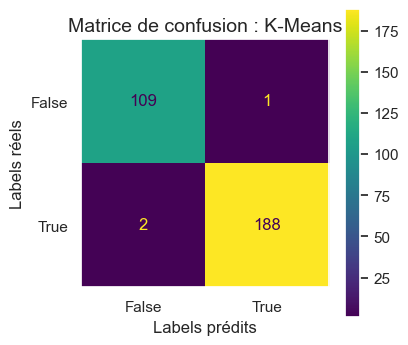

In [34]:
# Visualisation - Matrice de confusion
plt.rcParams["figure.figsize"] = (4,4)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_kmeans_scaled, display_labels=['False','True'])
disp.plot()
plt.title('Matrice de confusion : K-Means', size=14)
plt.ylabel('Labels réels', size=12)
plt.xlabel('Labels prédits', size=12)
plt.grid(None)

Interprétation : 
- TN (True Negatives) : 108 vrais négatifs
- FP (False Positives) : 2 négatifs mal classés comme positifs
- FN (False Negatives) : 2 positifs mal classés comme négatifs
- TP (True Positives) : 188 vrais positifs

Passons à l'affichage des prédictions par billet de banque suite au test avec le modèle K-Means : 

In [37]:
# 1. Création d'une copie de X_test pour affichage des prédictions
df_test_kmeans1 = X_test.copy()

In [38]:
# 2. Ajout de la vraie cible (valeurs connues)
df_test_kmeans1['cible (is_genuine)'] = y_test.values

In [39]:
# 3. Mappage des clusters à "True"/"False"
# → On vérifie quel cluster correspond majoritairement aux vrais billets

# Pour mapper cluster → vrai/faux :
# On teste deux hypothèses : 0 = True ou 0 = False
# On choisit celle qui donne la meilleure précision

mapping_1 = np.where(y_pred_scaled_kmeans == 0, True, False)  # Cluster 0 = vrais billets
mapping_2 = np.where(y_pred_scaled_kmeans == 0, False, True)  # Cluster 0 = faux billets

# Choisir la meilleure correspondance
accuracy_1 = accuracy_score(y_test, mapping_1)
accuracy_2 = accuracy_score(y_test, mapping_2)

if accuracy_1 >= accuracy_2:
    y_pred_scaled_kmeans = mapping_1
else:
   y_pred_scaled_kmeans = mapping_2

In [40]:
# 4. Ajout de la prédiction sous forme texte
df_test_kmeans1['prediction'] = ['True' if p else 'False' for p in y_pred_scaled_kmeans]

In [41]:
# 5. Ajout d'une colonne "correct" pour comparer la prédiction et la vraie cible
df_test_kmeans1['correct'] = df_test_kmeans1['cible (is_genuine)'] == y_pred_scaled_kmeans

In [42]:
# 6. Faux billets prédits comme vrais (FP) - 2 billets
kmeans1_faux_classés_vrais = df_test_kmeans1[(df_test_kmeans1['cible (is_genuine)'] == False) & (df_test_kmeans1['prediction'] == 'True')]
kmeans1_faux_classés_vrais

,diagonal,height_left,height_right,margin_low,margin_up,length,cible (is_genuine),prediction,correct
1073,172.13,103.67,103.82,4.27,3.22,112.15,False,True,False


In [43]:
# 7. Faux billets prédits comme faux (TN) - 108 billets
kmeans1_faux_classés_faux = df_test_kmeans1[(df_test_kmeans1['cible (is_genuine)'] == False) & (df_test_kmeans1['prediction'] == 'False')]
kmeans1_faux_classés_faux

,diagonal,height_left,height_right,margin_low,margin_up,length,cible (is_genuine),prediction,correct
1116,172.26,103.90,104.12,4.99,3.42,111.27,False,False,True
1368,171.65,104.32,104.38,5.65,3.24,112.30,False,False,True
1063,171.44,103.99,104.04,4.81,3.49,111.74,False,False,True
1272,171.73,103.74,104.38,5.14,3.16,111.73,False,False,True
1432,171.96,103.92,104.23,5.00,3.35,111.16,False,False,True
...,...,...,...,...,...,...,...,...,...
1404,171.76,103.79,104.05,5.12,3.22,112.08,False,False,True
1156,171.78,104.33,103.58,6.01,3.26,111.30,False,False,True
1276,172.47,104.27,104.10,4.88,3.33,110.68,False,False,True
1265,172.37,104.54,104.03,5.82,3.41,111.45,False,False,True


In [44]:
# 8. Vrais billets prédits comme faux (FN) - 2 billets
kmeans1_vrais_classés_faux = df_test_kmeans1[(df_test_kmeans1['cible (is_genuine)'] == True) & (df_test_kmeans1['prediction'] == 'False')]
kmeans1_vrais_classés_faux

,diagonal,height_left,height_right,margin_low,margin_up,length,cible (is_genuine),prediction,correct
743,172.30,104.58,104.17,4.36,3.33,112.98,True,False,False
626,171.98,104.44,104.08,4.67,3.21,112.73,True,False,False


In [45]:
# 9. Vrais billets prédits comme vrais (TP) - 188 billets
kmeans1_vrais_classés_vrais = df_test_kmeans1[(df_test_kmeans1['cible (is_genuine)'] == True) & (df_test_kmeans1['prediction'] == 'True')]
kmeans1_vrais_classés_vrais

,diagonal,height_left,height_right,margin_low,margin_up,length,cible (is_genuine),prediction,correct
422,171.53,103.53,103.63,4.04000,2.96,112.76,True,True,True
413,172.30,103.66,103.50,4.17914,3.16,112.95,True,True,True
451,172.17,103.79,103.54,4.07000,2.78,113.03,True,True,True
861,171.86,104.21,103.74,4.43000,2.90,113.65,True,True,True
741,172.17,103.75,103.29,4.43000,2.88,113.38,True,True,True
...,...,...,...,...,...,...,...,...,...
111,172.03,103.96,103.58,4.06000,2.85,113.02,True,True,True
780,172.41,103.95,103.79,4.09755,3.13,113.41,True,True,True
983,172.33,103.69,103.66,3.76000,3.09,113.66,True,True,True
799,172.50,104.03,103.79,4.27000,2.90,112.72,True,True,True


2/ DONNEES NON STANDARDISEES :

In [47]:
#Rappel : Séparation des variables d’entrée et variable cible
# X = Variables d'entrée (toutes les colonnes de dimensions)
# Y = Variable cible (vrai ou faux billet)

#Scindons le dataset en une partie entraînement (80%) + une partie test (20%)
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.20, random_state=42)  #Random state : même séparation effectuée à chaque exécution du code (n'importe quel entier fait l'affaire)

In [48]:
#Transformation en dataframe
X_train_df = pd.DataFrame(X_train)
y_train_df = pd.DataFrame(y_train)
X_test_df = pd.DataFrame(X_test)
y_test_df = pd.DataFrame(y_test)

In [49]:
#Création dataframe d'entraînement
df_train = pd.merge(y_train_df, X_train_df, left_index=True, right_index=True)
df_train.head(3)

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length
382,True,172.28,104.62,103.80,4.08,3.08,113.26
538,True,171.90,104.50,103.49,4.08,2.82,113.50
1493,False,171.63,104.33,104.61,4.88,3.35,112.16


In [50]:
#Création dataframe de test
df_test = pd.merge(y_test_df, X_test_df, left_index=True, right_index=True)
df_test.head(3)

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length
1116,False,172.26,103.90,104.12,4.99,3.42,111.27
1368,False,171.65,104.32,104.38,5.65,3.24,112.30
422,True,171.53,103.53,103.63,4.04,2.96,112.76


In [51]:
#Détermination du nombre de clusters à retenir

# Définition d'une liste vide pour enregistrer les inerties :   
inertia_list = [ ]

# Liste de nombres de clusters qu'on veut tester : 
k_list = range(1, 10)

# Pour chaque nombre de clusters : 
for k in k_list : 
    
    # On instancie un k-means pour k clusters
    kmeans = KMeans(n_clusters=k)
    
     # On entraine le modèle K-Means sur les données du dataset
    kmeans.fit(X_train_df)
    
    # On enregistre l'inertie obtenue (=mesure à quel point les points sont proches de leur centroïde dans chaque cluster) : 
    inertia_list.append(kmeans.inertia_)

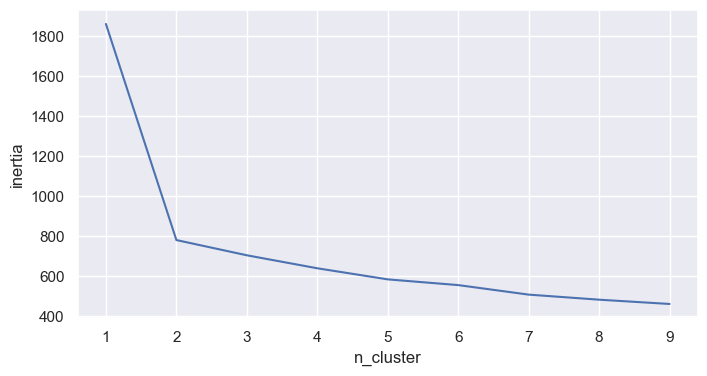

In [52]:
#Affichage courbe des inerties pour repérer le "coude" (constatation de la cassure)
fig, ax = plt.subplots(1,1,figsize=(8,4))

ax.set_ylabel("inertia")               # x = nb de clusters
ax.set_xlabel("n_cluster")             # y = valeur de l'inertie intraclasse
ax = plt.plot(k_list, inertia_list)

Interprétation selon la "méthode du coude" : 
- 1ere cassure la plus forte se situe à partir de 2 clusters
- Une 2nde cassure moins forte située à 4 clusters
- On devrait partir sur un total de 5 clusters mais cela n'a pas de sens car on souhaite prédire si un billet est vrai ou faux : logiquement on devrait donc avoir 2 clusters (1 cluster = vrais billets ; 2e cluster = faux billets). On retiendra donc 2 clusters in fine.

In [54]:
#Application de l'algorithme du K-Means
k_means = KMeans(n_clusters=2, random_state = 808)
k_means.fit(X_train_df)

#Libellés clusters
labels_kmeans = k_means.labels_
#Centroïdes
centroids_kmeans = k_means.cluster_centers_

In [55]:
#Ajout de la colonne avec le n° de cluster issu du k-means
df_train['cluster_kmeans'] = labels_kmeans
df_train.head(3)

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length,cluster_kmeans
382,True,172.28,104.62,103.80,4.08,3.08,113.26,1
538,True,171.90,104.50,103.49,4.08,2.82,113.50,1
1493,False,171.63,104.33,104.61,4.88,3.35,112.16,0


In [56]:
# Pour chaque cluster, nombre de vrais/faux billets
df_train_countbycluster_kmeans = df_train.groupby(['cluster_kmeans','is_genuine'])['diagonal'].count().reset_index(name='count')
print('Nombre de vrais/faux billets par cluster :')
df_train_countbycluster_kmeans

Nombre de vrais/faux billets par cluster :


,cluster_kmeans,is_genuine,count
0,0,False,374
1,0,True,2
2,1,False,16
3,1,True,808


In [57]:
# Attribuer un vrai/faux à chaque cluster du "df_train" (on retient le nombre max entre vrai et faux billet par cluster)

df_train_typebycluster_kmeans = pd.DataFrame()
df_train_typebycluster_kmeans.head()

# Liste temporaire pour stocker les morceaux
df_temp = []

# Pour chaque cluster :
for n in range(2): 
    df = df_train_countbycluster_kmeans.loc[df_train_countbycluster_kmeans['cluster_kmeans']==n].copy()      
    if not df.empty:
        df['type'] = df.loc[df['count']==df['count'].max(), 'is_genuine'].values[0]         # Valeur de is_genuine au type du cluster
        df_temp.append(df)                                                                  # On stocke le DataFrame dans la liste

# Concaténation finale après la boucle
df_train_typebycluster_kmeans = pd.concat(df_temp, ignore_index=True)

df_train_typebycluster_kmeans.head(8)

,cluster_kmeans,is_genuine,count,type
0,0,False,374,False
1,0,True,2,False
2,1,False,16,True
3,1,True,808,True


In [58]:
# Affichage final du type de billets par cluster (K-Means)
df_train_typebycluster_kmeans = df_train_typebycluster_kmeans.drop(['count','is_genuine'], axis=1)
# Suppression lignes en double
df_train_typebycluster_kmeans = df_train_typebycluster_kmeans.drop_duplicates(subset=['cluster_kmeans', 'type'])

print('Type de billets par cluster - K-Means :')
df_train_typebycluster_kmeans

Type de billets par cluster - K-Means :


,cluster_kmeans,type
0,0,False
2,1,True


In [59]:
# Application du modèle sur le jeu de test
y_pred_kmeans = k_means.predict(X_test)

In [60]:
# Score
score = k_means.score(X_test, y_test)
print('Score du modèle :',score)

Score du modèle : -192.5942753084547


In [61]:
# Coefficient de silhouette (compris entre -1 [mauvais] et 1 [excellent])
print("Silhouette_score : ", silhouette_score(X_test, k_means.predict(X_test)))

Silhouette_score :  0.500260289003931


Interprétation : 
- Proche de +1 : les clusters sont bien séparés et bien définis (très bon regroupement)
- Proche de 0 : les clusters se chevauchent, mauvaise séparation => c'est notre cas ici
- Proche de -1 : les points sont mal classés (ils sont plus proches d’un autre cluster que du leur)

In [63]:
#  Faire correspondre les clusters aux vraies classes
def remap_clusters_to_labels_2(y_pred_kmeans, y_test):
    label_mapping = {}
    for cluster in np.unique(y_pred_kmeans):
        mask = y_pred_kmeans == cluster
        majority_label = pd.Series(y_test[mask]).mode()[0]  # Plus robuste que scipy
        label_mapping[cluster] = majority_label
    return np.array([label_mapping[cluster] for cluster in y_pred_kmeans])

# Mapper les clusters aux vraies classes
mapped_labels_2 = remap_clusters_to_labels_2(y_pred_kmeans, y_test)

# Accuracy score
print("Accuracy score du modèle K-Means :", round(accuracy_score(y_test, mapped_labels_2),2))
print("Pourcentage d'erreur du modèle K-Means :", round((1 - accuracy_score(y_test, mapped_labels)), 2))

Accuracy score du modèle K-Means : 0.98
Pourcentage d'erreur du modèle K-Means : 0.01


Interprétation : Cela signifie que 98% des billets sont bien classés (vrais/faux) et que le pourcentage d'erreur est de 2%.

In [65]:
# Aligner les clusters sur les classes (True/False)

# Initialisation d'un tableau pour mapper les clusters à la classe majoritaire (pour chaque cluster donne le type de billet majoritaire)
labels_map = {}

# Pour chaque cluster, on regarde la classe majoritaire réelle
for cluster in np.unique(y_pred_kmeans):
    mask = (y_pred_kmeans == cluster)             #Création masque booléen pour sélectionner les éléments où KMeans a prédit ce cluster
    true_labels = y_test[mask]                    #Récupération des vraies classes (y_test) correspondantes

    if len(true_labels) > 0:                      #Identification classe majoritaire du cluster
        values, counts = np.unique(true_labels, return_counts=True)      #Nombre de True/False par cluster
        majority_class = values[np.argmax(counts)]                       #Sélection de la classe la plus fréquente (majority_class)
        labels_map[cluster] = majority_class                             #Enregistrement de la classe maj dans labels_map[cluster]

# On applique ce mapping pour créer les prédictions alignées (remplacement de chaque prédiction KMeans par la classe correspondante)
y_pred_aligned_kmeans = np.array([labels_map[cluster] for cluster in y_pred_kmeans])   #In fine on a tableau y_pred_aligned_kmeans contenant uniquement des True/False (comme y_test)

In [66]:
# Matrice de confusion
cm_kmeans = metrics.confusion_matrix(y_test, y_pred_aligned_kmeans)
print(cm_kmeans)

[[104   6]
 [  0 190]]


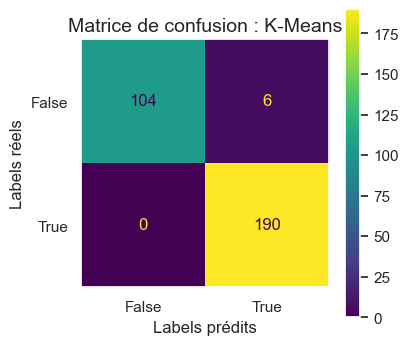

In [67]:
# Visualisation - Matrice de confusion
plt.rcParams["figure.figsize"] = (4,4)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_kmeans, display_labels=['False','True'])
disp.plot()
plt.title('Matrice de confusion : K-Means', size=14)
plt.ylabel('Labels réels', size=12)
plt.xlabel('Labels prédits', size=12)
plt.grid(None)

Interprétation : 
- TN (True Negatives) : 104 vrais négatifs
- FP (False Positives) : 6 négatifs mal classés comme positifs
- FN (False Negatives) : 0 positifs mal classés comme négatifs
- TP (True Positives) : 190 vrais positifs

Passons à l'affichage des prédictions par billet de banque suite au test avec le modèle K-Means : 

In [70]:
# 1. Création d'une copie de X_test pour affichage des prédictions
df_test_kmeans2 = X_test.copy()

In [71]:
# 2. Ajout de la vraie cible (valeurs connues)
df_test_kmeans2['cible (is_genuine)'] = y_test.values

In [72]:
# 3. Mappage des clusters à "True"/"False"
# → On vérifie quel cluster correspond majoritairement aux vrais billets

# Pour mapper cluster → vrai/faux :
# On teste deux hypothèses : 0 = True ou 0 = False
# On choisit celle qui donne la meilleure précision

mapping_bis_1 = np.where(y_pred_aligned_kmeans == 0, True, False)  # Cluster 0 = vrais billets
mapping_bis_2 = np.where(y_pred_aligned_kmeans == 0, False, True)  # Cluster 0 = faux billets

# Choisir la meilleure correspondance
accuracy_bis_1 = accuracy_score(y_test, mapping_1)
accuracy_bis_2 = accuracy_score(y_test, mapping_2)

if accuracy_bis_1 >= accuracy_bis_2:
    y_pred_aligned_kmeans= mapping_1
else:
    y_pred_aligned_kmeans= mapping_2

In [73]:
# 4. Ajout de la prédiction sous forme texte
df_test_kmeans2['prediction'] = ['True' if p else 'False' for p in y_pred_kmeans]

In [74]:
# 5. Ajout d'une colonne "correct" pour comparer la prédiction et la vraie cible
df_test_kmeans2['correct'] = df_test_kmeans2['cible (is_genuine)'] == y_pred_kmeans

In [75]:
# 6. Faux billets prédits comme vrais (FP) - 6 billets
kmeans2_faux_classés_vrais = df_test_kmeans2[(df_test_kmeans2['cible (is_genuine)'] == False) & (df_test_kmeans2['prediction'] == 'True')]
kmeans2_faux_classés_vrais

,diagonal,height_left,height_right,margin_low,margin_up,length,cible (is_genuine),prediction,correct
1190,171.45,104.21,104.18,4.55,3.52,113.21,False,True,False
1452,171.93,104.15,103.98,4.57,3.57,112.71,False,True,False
1281,171.62,104.53,103.64,4.89,3.16,112.54,False,True,False
1073,172.13,103.67,103.82,4.27,3.22,112.15,False,True,False
1325,171.83,104.39,104.17,5.51,3.33,113.64,False,True,False
1341,171.94,104.21,104.10,4.28,3.47,112.23,False,True,False


In [76]:
# 7. Faux billets prédits comme faux (TN) - 104 billets
kmeans2_faux_classés_faux = df_test_kmeans2[(df_test_kmeans2['cible (is_genuine)'] == False) & (df_test_kmeans2['prediction'] == 'False')]
kmeans2_faux_classés_faux

,diagonal,height_left,height_right,margin_low,margin_up,length,cible (is_genuine),prediction,correct
1116,172.26,103.90,104.12,4.99,3.42,111.27,False,False,True
1368,171.65,104.32,104.38,5.65,3.24,112.30,False,False,True
1063,171.44,103.99,104.04,4.81,3.49,111.74,False,False,True
1272,171.73,103.74,104.38,5.14,3.16,111.73,False,False,True
1432,171.96,103.92,104.23,5.00,3.35,111.16,False,False,True
...,...,...,...,...,...,...,...,...,...
1404,171.76,103.79,104.05,5.12,3.22,112.08,False,False,True
1156,171.78,104.33,103.58,6.01,3.26,111.30,False,False,True
1276,172.47,104.27,104.10,4.88,3.33,110.68,False,False,True
1265,172.37,104.54,104.03,5.82,3.41,111.45,False,False,True


In [77]:
# 8. Vrais billets prédits comme faux (FN) - 0 billets
kmeans2_vrais_classés_faux = df_test_kmeans2[(df_test_kmeans2['cible (is_genuine)'] == True) & (df_test_kmeans2['prediction'] == 'False')]
kmeans2_vrais_classés_faux

,diagonal,height_left,height_right,margin_low,margin_up,length,cible (is_genuine),prediction,correct


In [78]:
# 9. Vrais billets prédits comme vrais (TP) - 190 billets
kmeans2_vrais_classés_vrais = df_test_kmeans2[(df_test_kmeans2['cible (is_genuine)'] == True) & (df_test_kmeans2['prediction'] == 'True')]
kmeans2_vrais_classés_vrais

,diagonal,height_left,height_right,margin_low,margin_up,length,cible (is_genuine),prediction,correct
422,171.53,103.53,103.63,4.04000,2.96,112.76,True,True,True
413,172.30,103.66,103.50,4.17914,3.16,112.95,True,True,True
451,172.17,103.79,103.54,4.07000,2.78,113.03,True,True,True
861,171.86,104.21,103.74,4.43000,2.90,113.65,True,True,True
741,172.17,103.75,103.29,4.43000,2.88,113.38,True,True,True
...,...,...,...,...,...,...,...,...,...
111,172.03,103.96,103.58,4.06000,2.85,113.02,True,True,True
780,172.41,103.95,103.79,4.09755,3.13,113.41,True,True,True
983,172.33,103.69,103.66,3.76000,3.09,113.66,True,True,True
799,172.50,104.03,103.79,4.27000,2.90,112.72,True,True,True


<div style="background-color: RGB(51,165,182);" >
<h2 style="margin: auto; padding: 20px; color:#fff; ">Etape 3 - Prédiction du type du billet : Régression logistique (classification supervisée)</h2>
</div>

Nous allons effectuer la prédiction à la fois : 
- Sur les données standardisées
- Sur les données non standardisées

1/ SUR DONNEES STANDARDISEES :

In [82]:
#Pour rappel : Séparation des variables d’entrée et variable cible
# X = Variables d'entrée (toutes les colonnes de dimensions)
# Y = Variable cible (vrai ou faux billet)

#Scindons le dataset en une partie entraînement (80%) + une partie test (20%)
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.20, random_state=42)  #Random state : même séparation effectuée à chaque exécution du code (n'importe quel entier fait l'affaire)

In [83]:
#Standardisation des données (X_train) 
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)                                #Scaling - instancie/entraîne & transforme
pd.DataFrame(X_train_scaled).describe().round(2).iloc[1:3:, : ]               #Vérification moyenne = 0 et écart-type = 1

#Standardisation des données (X_test)
X_test_scaled = scaler.transform(X_test)                                     
pd.DataFrame(X_test_scaled).describe().round(2).iloc[1:3:, : ]               #Vérification moyenne = 0 et écart-type = 1

,0,1,2,3,4,5
mean,0.02,-0.01,0.01,0.08,0.01,-0.07
std,0.96,0.97,0.99,1.01,1.00,0.96


In [84]:
#Application de la régression logistique
logisticReg1 = LogisticRegression(random_state=808).fit(X_train_scaled, y_train)

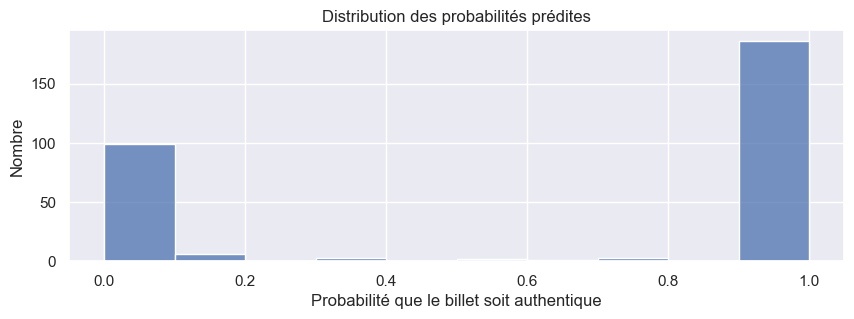

In [85]:
#Histogramme des probabilités
y_hat_proba_1 = logisticReg1.predict_proba(X_test_scaled)[:,1]    #Prédiction des probabilités sur l'ensemble test ou complet (au choix)

# Affichage de l'histogramme des probabilités
plt.figure(figsize=(10,3))
sns.histplot(y_hat_proba_1)
plt.title("Distribution des probabilités prédites")
plt.xlabel("Probabilité que le billet soit authentique")
plt.ylabel("Nombre")
plt.show()

Explication de l'histogramme des probabilités :

But : Affiche la distribution des probabilités prédites par le modèle (y_hat_proba => proba qu'un billet soit vrai)
Axe x : valeurs entre 0 et 1 → ce sont les probabilités prédites
Axe y : nombre d’échantillons ayant une certaine probabilité (fréquence)
Interprétation :

2 pics distincts en proba 0 et 1 : le modèle est fiable et performant (distingue bien les vrais des faux billets) => c'est notre cas ici
Si le modèle n'était pas confiant, on aurait plutôt une distribution des proba concentrée au centre (proba proche de 50%)

In [87]:
#Calcul de l'accuracy score
y_pred_1 = logisticReg1.predict(X_test_scaled)    #Entrainement des prédictions
score_reg_logistique_1 = accuracy_score(y_test, y_pred_1)   #Doit être proche de 100%   #On peut aussi utiliser le code suivant : score = logisticReg.score(X_test, y_test)
print('Accuracy Score du modèle (% de prédictions correctes) :',score_reg_logistique_1)
print(' ')
print("% d'erreur du modèle :", round(1-score_reg_logistique_1,2))

Accuracy Score du modèle (% de prédictions correctes) : 0.9933333333333333
 
% d'erreur du modèle : 0.01


Interprétation : Cela signifie que 99 % des billets sont bien classés (vrais/faux) et que le pourcentage d'erreur est de 1%.

In [89]:
#Matrice de confusion (tableau 2x2 avec en colonnes le nombre de valeurs vraies et en rangées le nombre de valeurs prédites)
cm_reg_logistique1 = confusion_matrix(y_test, y_pred_1)
print('Matrice de confusion :')
print(cm_reg_logistique1)

Matrice de confusion :
[[108   2]
 [  0 190]]


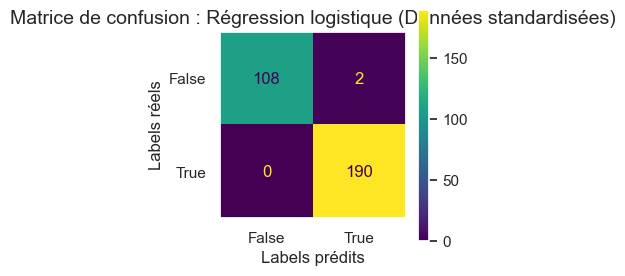

In [90]:
# Visualisation - Matrice de confusion
plt.rcParams["figure.figsize"] = (3,3)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_reg_logistique1, display_labels=['False','True'])
disp.plot()
plt.title('Matrice de confusion : Régression logistique (Données standardisées)', size=14)
plt.ylabel('Labels réels', size=12)
plt.xlabel('Labels prédits', size=12)
plt.grid(None)

Explication de la matrice de confusion :

- Compare les valeurs réelles (y_test) aux valeurs prédites (y_pred) par le modèle
- En ligne : ce sont les billets réels
- En colonne : ce sont les billets prédits
- Dans le cas d'une classification binaire (c'est notre cas ici), la matrice a la forme suivante :
  - [[TN  FP]
  - [FN  TP]]
  - TN (True Negatives) : nombre de cas négatifs bien classés
  - FP (False Positives) : nombre de cas négatifs mal classés comme positifs
  - FN (False Negatives) : nombre de cas positifs mal classés comme négatifs
  - TP (True Positives) : nombre de cas positifs bien classés

Interprétation : 
- TN (True Negatives) : 107 vrais négatifs
- FP (False Positives) : 3 négatifs mal classés comme positifs
- FN (False Negatives) : 0 positifs mal classés comme négatifs
- TP (True Positives) : 190 vrais positifs
- Pour résumer : Notre modèle a fait 3 erreurs en classant 3 faux billets comme des vrais. Toutes les autres prédictions sont correctes.

In [93]:
# 8. Création d'une copie de X_test_scaled pour l'affichage des prédictions du test
df_test_rl1 = X_test.copy()

# 9. Ajout de la vraie cible et de la prédiction dans le dataframe de test
df_test_rl1['cible (is_genuine)'] = y_test.values
df_test_rl1['prediction'] = ['True' if p == 1 else 'False' for p in y_pred_1]
df_test_rl1

,diagonal,height_left,height_right,margin_low,margin_up,length,cible (is_genuine),prediction
1116,172.26,103.90,104.12,4.99000,3.42,111.27,False,False
1368,171.65,104.32,104.38,5.65000,3.24,112.30,False,False
422,171.53,103.53,103.63,4.04000,2.96,112.76,True,True
413,172.30,103.66,103.50,4.17914,3.16,112.95,True,True
451,172.17,103.79,103.54,4.07000,2.78,113.03,True,True
...,...,...,...,...,...,...,...,...
983,172.33,103.69,103.66,3.76000,3.09,113.66,True,True
799,172.50,104.03,103.79,4.27000,2.90,112.72,True,True
1265,172.37,104.54,104.03,5.82000,3.41,111.45,False,False
1150,171.79,104.86,104.34,5.39000,3.14,113.02,False,False


In [94]:
# 10. Ajout d'une colonne "correct" pour comparer les prédictions
df_test_rl1['correct'] = df_test_rl1['cible (is_genuine)'] == (y_pred_1)
df_test_rl1

,diagonal,height_left,height_right,margin_low,margin_up,length,cible (is_genuine),prediction,correct
1116,172.26,103.90,104.12,4.99000,3.42,111.27,False,False,True
1368,171.65,104.32,104.38,5.65000,3.24,112.30,False,False,True
422,171.53,103.53,103.63,4.04000,2.96,112.76,True,True,True
413,172.30,103.66,103.50,4.17914,3.16,112.95,True,True,True
451,172.17,103.79,103.54,4.07000,2.78,113.03,True,True,True
...,...,...,...,...,...,...,...,...,...
983,172.33,103.69,103.66,3.76000,3.09,113.66,True,True,True
799,172.50,104.03,103.79,4.27000,2.90,112.72,True,True,True
1265,172.37,104.54,104.03,5.82000,3.41,111.45,False,False,True
1150,171.79,104.86,104.34,5.39000,3.14,113.02,False,False,True


In [95]:
# 11. Affichage des faux billets prédits comme vrais (3 billets) - FP
rl1_faux_classés_vrais = df_test_rl1[(df_test_rl1['cible (is_genuine)'] == False) & (df_test_rl1['prediction'] == 'True')]
rl1_faux_classés_vrais

,diagonal,height_left,height_right,margin_low,margin_up,length,cible (is_genuine),prediction,correct
1190,171.45,104.21,104.18,4.55,3.52,113.21,False,True,False
1073,172.13,103.67,103.82,4.27,3.22,112.15,False,True,False


In [96]:
# 12. Affichage des faux billets prédits comme faux (107 billets) - TN
rl1_faux_classés_faux = df_test_rl1[(df_test_rl1['cible (is_genuine)'] == False) & (df_test_rl1['prediction'] == 'False')]
rl1_faux_classés_faux

,diagonal,height_left,height_right,margin_low,margin_up,length,cible (is_genuine),prediction,correct
1116,172.26,103.90,104.12,4.99,3.42,111.27,False,False,True
1368,171.65,104.32,104.38,5.65,3.24,112.30,False,False,True
1063,171.44,103.99,104.04,4.81,3.49,111.74,False,False,True
1272,171.73,103.74,104.38,5.14,3.16,111.73,False,False,True
1432,171.96,103.92,104.23,5.00,3.35,111.16,False,False,True
...,...,...,...,...,...,...,...,...,...
1404,171.76,103.79,104.05,5.12,3.22,112.08,False,False,True
1156,171.78,104.33,103.58,6.01,3.26,111.30,False,False,True
1276,172.47,104.27,104.10,4.88,3.33,110.68,False,False,True
1265,172.37,104.54,104.03,5.82,3.41,111.45,False,False,True


In [97]:
# 13. Affichage des vrais billets prédits comme faux (0 billets) - FN
rl1_vrais_classés_faux = df_test_rl1[(df_test_rl1['cible (is_genuine)'] == True) & (df_test_rl1['prediction']== 'False')]
rl1_vrais_classés_faux

,diagonal,height_left,height_right,margin_low,margin_up,length,cible (is_genuine),prediction,correct


In [98]:
# 14. Affichage des vrais billets prédits comme vrais (190 billets) - TP
rl1_vrais_classés_vrais = df_test_rl1[(df_test_rl1['cible (is_genuine)'] == True) & (df_test_rl1['prediction'] == 'True')]
rl1_vrais_classés_vrais

,diagonal,height_left,height_right,margin_low,margin_up,length,cible (is_genuine),prediction,correct
422,171.53,103.53,103.63,4.04000,2.96,112.76,True,True,True
413,172.30,103.66,103.50,4.17914,3.16,112.95,True,True,True
451,172.17,103.79,103.54,4.07000,2.78,113.03,True,True,True
861,171.86,104.21,103.74,4.43000,2.90,113.65,True,True,True
741,172.17,103.75,103.29,4.43000,2.88,113.38,True,True,True
...,...,...,...,...,...,...,...,...,...
111,172.03,103.96,103.58,4.06000,2.85,113.02,True,True,True
780,172.41,103.95,103.79,4.09755,3.13,113.41,True,True,True
983,172.33,103.69,103.66,3.76000,3.09,113.66,True,True,True
799,172.50,104.03,103.79,4.27000,2.90,112.72,True,True,True


2/ SUR DONNEES NON STANDARDISEES :

In [100]:
#Pour rappel : Séparation des variables d’entrée et variable cible
# X = Variables d'entrée (toutes les colonnes de dimensions)
# Y = Variable cible (vrai ou faux billet)

#Scindons le dataset en une partie entraînement (80%) + une partie test (20%)
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.20, random_state=42)  #Random state : même séparation effectuée à chaque exécution du code (n'importe quel entier fait l'affaire)

In [101]:
#Application de la régression logistique
logisticReg2 = LogisticRegression(random_state=808).fit(X_train, y_train)

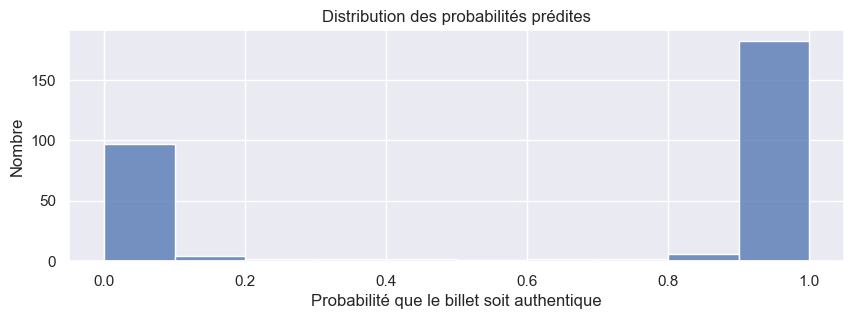

In [102]:
#Histogramme des probabilités
y_hat_proba_2 = logisticReg2.predict_proba(X_test)[:,1]    #Prédiction des probabilités sur l'ensemble test ou complet (au choix)

# Affichage de l'histogramme des probabilités
plt.figure(figsize=(10,3))
sns.histplot(y_hat_proba_2)
plt.title("Distribution des probabilités prédites")
plt.xlabel("Probabilité que le billet soit authentique")
plt.ylabel("Nombre")
plt.show()

Explication de l'histogramme des probabilités : 
- But : Affiche la distribution des probabilités prédites par le modèle (y_hat_proba => proba qu'un billet soit vrai)
- Axe x : valeurs entre 0 et 1 → ce sont les probabilités prédites
- Axe y : nombre d’échantillons ayant une certaine probabilité (fréquence)

Interprétation : 
- 2 pics distincts en proba 0 et 1 : le modèle est fiable et performant (distingue bien les vrais des faux billets) => c'est notre cas ici
- Si le modèle n'était pas confiant, on aurait plutôt une distribution des proba concentrée au centre (proba proche de 50%)

In [104]:
#Calcul de l'accuracy score
y_pred_2 = logisticReg2.predict(X_test)    #Entrainement des prédictions
score_reg_logistique_2 = accuracy_score(y_test, y_pred_2)   #Doit être proche de 100%   #On peut aussi utiliser le code suivant : score = logisticReg.score(X_test, y_test)
print('Accuracy Score du modèle (% de prédictions correctes) :',score_reg_logistique_2)
print(' ')
print("% d'erreur du modèle :", round(1-score_reg_logistique_2,2))

Accuracy Score du modèle (% de prédictions correctes) : 0.99
 
% d'erreur du modèle : 0.01


Interprétation : Cela signifie que 99 % des billets sont bien classés (vrais/faux) et que le pourcentage d'erreur est de 1%.

In [106]:
#Matrice de confusion (tableau 2x2 avec en colonnes le nombre de valeurs vraies et en rangées le nombre de valeurs prédites)
cm_reg_logistique2 = confusion_matrix(y_test, y_pred_2)
print('Matrice de confusion :')
print(cm_reg_logistique2)

Matrice de confusion :
[[107   3]
 [  0 190]]


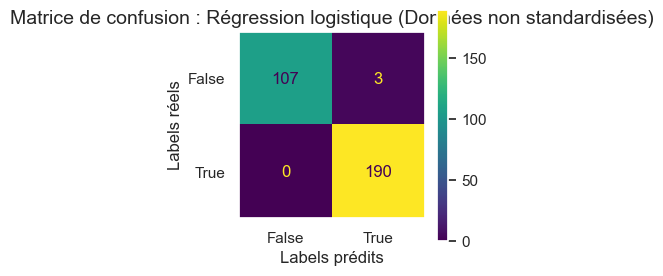

In [107]:
# Visualisation - Matrice de confusion
plt.rcParams["figure.figsize"] = (3,3)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_reg_logistique2, display_labels=['False','True'])
disp.plot()
plt.title('Matrice de confusion : Régression logistique (Données non standardisées)', size=14)
plt.ylabel('Labels réels', size=12)
plt.xlabel('Labels prédits', size=12)
plt.grid(None)

Explication de la matrice de confusion : 
- 1. Compare les valeurs réelles (y_test) aux valeurs prédites (y_pred) par le modèle
- 2. En ligne : ce sont les billets réels
- 3. En colonne : ce sont les billets prédits
- 4. Dans le cas d'une classification binaire (c'est notre cas ici), la matrice a la forme suivante :
-       [[TN  FP]
-       [FN  TP]]
-       TN (True Negatives) : nombre de cas négatifs bien classés
-       FP (False Positives) : nombre de cas négatifs mal classés comme positifs
-       FN (False Negatives) : nombre de cas positifs mal classés comme négatifs
-       TP (True Positives) : nombre de cas positifs bien classés

Interprétation : 
- TN (True Negatives) : 107 vrais négatifs
- FP (False Positives) : 3 négatifs mal classés comme positifs
- FN (False Negatives) : 0 positifs mal classés comme négatifs
- TP (True Positives) : 190 vrais positifs

In [110]:
print(np.unique(y_test))

[False  True]


Interprétation : 
- En Python (et donc avec scikit-learn), False est équivalent à 0 et True est équivalent à 1
- On a donc Classe 0 (False) = faux billet et Classe 1 (True) = vrai billet
- |                                | Prédit : Faux billet | Prédit : Vrai billet |
| ------------------------------ | -------------------- | -------------------- |
| **Réel : Faux billet** (False) | 107                  | 3                    |
| **Réel : Vrai billet** (True)  | 0                    | 190                  |
- Pour résumer : Notre modèle a fait 3 erreurs en classant 3 faux billets comme des vrais. Toutes les autres prédictions sont correctes.

In [112]:
# 8. Création d'une copie de X_test_scaled pour l'affichage des prédictions du test
df_test_rl2 = X_test.copy()

# 9. Ajout de la vraie cible et de la prédiction dans le dataframe de test
df_test_rl2['cible (is_genuine)'] = y_test.values
df_test_rl2['prediction'] = ['True' if p == 1 else 'False' for p in y_pred_2]
df_test_rl2

,diagonal,height_left,height_right,margin_low,margin_up,length,cible (is_genuine),prediction
1116,172.26,103.90,104.12,4.99000,3.42,111.27,False,False
1368,171.65,104.32,104.38,5.65000,3.24,112.30,False,False
422,171.53,103.53,103.63,4.04000,2.96,112.76,True,True
413,172.30,103.66,103.50,4.17914,3.16,112.95,True,True
451,172.17,103.79,103.54,4.07000,2.78,113.03,True,True
...,...,...,...,...,...,...,...,...
983,172.33,103.69,103.66,3.76000,3.09,113.66,True,True
799,172.50,104.03,103.79,4.27000,2.90,112.72,True,True
1265,172.37,104.54,104.03,5.82000,3.41,111.45,False,False
1150,171.79,104.86,104.34,5.39000,3.14,113.02,False,False


In [113]:
# 10. Ajout d'une colonne "correct" pour comparer les prédictions
df_test_rl2['correct'] = df_test_rl2['cible (is_genuine)'] == (y_pred_2)
df_test_rl2

,diagonal,height_left,height_right,margin_low,margin_up,length,cible (is_genuine),prediction,correct
1116,172.26,103.90,104.12,4.99000,3.42,111.27,False,False,True
1368,171.65,104.32,104.38,5.65000,3.24,112.30,False,False,True
422,171.53,103.53,103.63,4.04000,2.96,112.76,True,True,True
413,172.30,103.66,103.50,4.17914,3.16,112.95,True,True,True
451,172.17,103.79,103.54,4.07000,2.78,113.03,True,True,True
...,...,...,...,...,...,...,...,...,...
983,172.33,103.69,103.66,3.76000,3.09,113.66,True,True,True
799,172.50,104.03,103.79,4.27000,2.90,112.72,True,True,True
1265,172.37,104.54,104.03,5.82000,3.41,111.45,False,False,True
1150,171.79,104.86,104.34,5.39000,3.14,113.02,False,False,True


In [114]:
# 11. Affichage des faux billets prédits comme vrais (3 billets) - FP
rl2_faux_classés_vrais = df_test_rl2[(df_test_rl2['cible (is_genuine)'] == False) & (df_test_rl2['prediction'] == 'True')]
rl2_faux_classés_vrais

,diagonal,height_left,height_right,margin_low,margin_up,length,cible (is_genuine),prediction,correct
1190,171.45,104.21,104.18,4.55,3.52,113.21,False,True,False
1073,172.13,103.67,103.82,4.27,3.22,112.15,False,True,False
1325,171.83,104.39,104.17,5.51,3.33,113.64,False,True,False


In [115]:
# 12. Affichage des faux billets prédits comme faux (107 billets) - TN
rl2_faux_classés_faux = df_test_rl2[(df_test_rl2['cible (is_genuine)'] == False) & (df_test_rl2['prediction'] == 'False')]
rl2_faux_classés_faux

,diagonal,height_left,height_right,margin_low,margin_up,length,cible (is_genuine),prediction,correct
1116,172.26,103.90,104.12,4.99,3.42,111.27,False,False,True
1368,171.65,104.32,104.38,5.65,3.24,112.30,False,False,True
1063,171.44,103.99,104.04,4.81,3.49,111.74,False,False,True
1272,171.73,103.74,104.38,5.14,3.16,111.73,False,False,True
1432,171.96,103.92,104.23,5.00,3.35,111.16,False,False,True
...,...,...,...,...,...,...,...,...,...
1404,171.76,103.79,104.05,5.12,3.22,112.08,False,False,True
1156,171.78,104.33,103.58,6.01,3.26,111.30,False,False,True
1276,172.47,104.27,104.10,4.88,3.33,110.68,False,False,True
1265,172.37,104.54,104.03,5.82,3.41,111.45,False,False,True


In [116]:
# 13. Affichage des vrais billets prédits comme faux (0 billets) - FN
rl2_vrais_classés_faux = df_test_rl2[(df_test_rl2['cible (is_genuine)'] == True) & (df_test_rl2['prediction']== 'False')]
rl2_vrais_classés_faux

,diagonal,height_left,height_right,margin_low,margin_up,length,cible (is_genuine),prediction,correct


In [117]:
# 14. Affichage des vrais billets prédits comme vrais (190 billets) - TP
rl2_vrais_classés_vrais = df_test_rl2[(df_test_rl2['cible (is_genuine)'] == True) & (df_test_rl2['prediction'] == 'True')]
rl2_vrais_classés_vrais

,diagonal,height_left,height_right,margin_low,margin_up,length,cible (is_genuine),prediction,correct
422,171.53,103.53,103.63,4.04000,2.96,112.76,True,True,True
413,172.30,103.66,103.50,4.17914,3.16,112.95,True,True,True
451,172.17,103.79,103.54,4.07000,2.78,113.03,True,True,True
861,171.86,104.21,103.74,4.43000,2.90,113.65,True,True,True
741,172.17,103.75,103.29,4.43000,2.88,113.38,True,True,True
...,...,...,...,...,...,...,...,...,...
111,172.03,103.96,103.58,4.06000,2.85,113.02,True,True,True
780,172.41,103.95,103.79,4.09755,3.13,113.41,True,True,True
983,172.33,103.69,103.66,3.76000,3.09,113.66,True,True,True
799,172.50,104.03,103.79,4.27000,2.90,112.72,True,True,True


<div style="background-color: RGB(51,165,182);" >
<h2 style="margin: auto; padding: 20px; color:#fff; ">Etape 4 - Prédiction du type du billet : KNN (classification supervisée)</h2>
</div>

SUR DONNEES STANDARDISEES : KNN (K-Nearest neighbors) nécessite une normalisation des données (utilisation StandardScaler)

In [120]:
# 1. Pour rappel : Séparation des variables d’entrée et variable cible
   # X = Variables d'entrée (toutes les colonnes de dimensions)
   # Y = Variable cible (vrai ou faux billet)

# 2. Séparation entraînement (80%) / test (20%)
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

In [121]:
# 3. Standardisation des données
scaler = StandardScaler()

# Pour X_train :
X_train_scaled = scaler.fit_transform(X_train)                                #Scaling - instancie/entraîne & transforme
pd.DataFrame(X_train_scaled).describe().round(2).iloc[1:3:, : ]               #Vérification moyenne = 0 et écart-type = 1

,0,1,2,3,4,5
mean,0.0,-0.0,0.0,0.0,0.0,-0.0
std,1.0,1.0,1.0,1.0,1.0,1.0


In [122]:
# Pour X_test :
X_test_scaled = scaler.transform(X_test)                                
pd.DataFrame(X_test_scaled).describe().round(2).iloc[1:3:, : ]               #Vérification moyenne = 0 et écart-type = 1

,0,1,2,3,4,5
mean,0.02,-0.01,0.01,0.08,0.01,-0.07
std,0.96,0.97,0.99,1.01,1.00,0.96


In [123]:
# 4. Application du modèle KNN

#Détermination du meilleur k
for k in range(1, 21):
    knn = KNeighborsClassifier(n_neighbors=k)
    scores = cross_val_score(knn, X_train_scaled, y_train, cv=5)
    print(f"k={k}, accuracy moyenne = {scores.mean():.3f}")

#Entraînement du modèle avec le meilleur k (ici k=9 ou k=13)
knn = KNeighborsClassifier(n_neighbors=9)
knn.fit(X_train_scaled, y_train)
y_pred_knn = knn.predict(X_test_scaled)

k=1, accuracy moyenne = 0.983
k=2, accuracy moyenne = 0.982
k=3, accuracy moyenne = 0.989
k=4, accuracy moyenne = 0.988
k=5, accuracy moyenne = 0.988
k=6, accuracy moyenne = 0.989
k=7, accuracy moyenne = 0.990
k=8, accuracy moyenne = 0.990
k=9, accuracy moyenne = 0.991
k=10, accuracy moyenne = 0.990
k=11, accuracy moyenne = 0.990
k=12, accuracy moyenne = 0.989
k=13, accuracy moyenne = 0.991
k=14, accuracy moyenne = 0.990
k=15, accuracy moyenne = 0.990
k=16, accuracy moyenne = 0.989
k=17, accuracy moyenne = 0.990
k=18, accuracy moyenne = 0.989
k=19, accuracy moyenne = 0.988
k=20, accuracy moyenne = 0.990


In [124]:
# 5. Score (évaluation des performances)
print("Accuracy score du modèle KNN:", round(accuracy_score(y_test, y_pred_knn),2))
print("% d'erreur du modèle KNN :", round(1-accuracy_score(y_test, y_pred_knn),2))

Accuracy score du modèle KNN: 0.99
% d'erreur du modèle KNN : 0.01


Interprétation : Cela signifie que 98 % des billets sont bien classés (vrais/faux) et que le pourcentage d'erreur est de 2%.

In [126]:
# 6. Matrice de confusion
cm_knn = confusion_matrix(y_test, y_pred_knn)
print('Matrice de confusion :')
print(cm_knn)

Matrice de confusion :
[[106   4]
 [  0 190]]


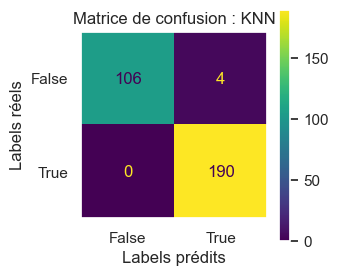

In [127]:
# 7. Visualisation - Matrice de confusion
plt.rcParams["figure.figsize"] = (3,3)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_knn, display_labels=['False','True'])
disp.plot()
plt.title('Matrice de confusion : KNN', size=12)
plt.ylabel('Labels réels', size=12)
plt.xlabel('Labels prédits', size=12)
plt.grid(None)

Interprétation : 
- TN (True Negatives) : 105 vrais négatifs
- FP (False Positives) : 5 négatifs mal classés comme positifs
- FN (False Negatives) : 0 positifs mal classés comme négatifs
- TP (True Positives) : 190 vrais positifs

In [129]:
# 8. Création d'une copie de X_test_scaled pour l'affichage des prédictions du test
df_test_knn = X_test.copy()

# 9. Ajout de la vraie cible et de la prédiction dans le dataframe de test
df_test_knn['cible (is_genuine)'] = y_test.values
df_test_knn['prediction'] = ['True' if p == 1 else 'False' for p in y_pred_knn]
df_test_knn

,diagonal,height_left,height_right,margin_low,margin_up,length,cible (is_genuine),prediction
1116,172.26,103.90,104.12,4.99000,3.42,111.27,False,False
1368,171.65,104.32,104.38,5.65000,3.24,112.30,False,False
422,171.53,103.53,103.63,4.04000,2.96,112.76,True,True
413,172.30,103.66,103.50,4.17914,3.16,112.95,True,True
451,172.17,103.79,103.54,4.07000,2.78,113.03,True,True
...,...,...,...,...,...,...,...,...
983,172.33,103.69,103.66,3.76000,3.09,113.66,True,True
799,172.50,104.03,103.79,4.27000,2.90,112.72,True,True
1265,172.37,104.54,104.03,5.82000,3.41,111.45,False,False
1150,171.79,104.86,104.34,5.39000,3.14,113.02,False,False


In [130]:
# 10. Ajout d'une colonne "correct" pour comparer les prédictions
df_test_knn['correct'] = df_test_knn['cible (is_genuine)'] == (y_pred_knn)
df_test_knn

,diagonal,height_left,height_right,margin_low,margin_up,length,cible (is_genuine),prediction,correct
1116,172.26,103.90,104.12,4.99000,3.42,111.27,False,False,True
1368,171.65,104.32,104.38,5.65000,3.24,112.30,False,False,True
422,171.53,103.53,103.63,4.04000,2.96,112.76,True,True,True
413,172.30,103.66,103.50,4.17914,3.16,112.95,True,True,True
451,172.17,103.79,103.54,4.07000,2.78,113.03,True,True,True
...,...,...,...,...,...,...,...,...,...
983,172.33,103.69,103.66,3.76000,3.09,113.66,True,True,True
799,172.50,104.03,103.79,4.27000,2.90,112.72,True,True,True
1265,172.37,104.54,104.03,5.82000,3.41,111.45,False,False,True
1150,171.79,104.86,104.34,5.39000,3.14,113.02,False,False,True


In [131]:
# 11. Affichage des faux billets prédits comme vrais (5 billets) - FP
knn_faux_classés_vrais = df_test_knn[(df_test_knn['cible (is_genuine)'] == False) & (df_test_knn['prediction'] == 'True')]
knn_faux_classés_vrais

,diagonal,height_left,height_right,margin_low,margin_up,length,cible (is_genuine),prediction,correct
1190,171.45,104.21,104.18,4.55,3.52,113.21,False,True,False
1281,171.62,104.53,103.64,4.89,3.16,112.54,False,True,False
1084,171.94,104.27,103.94,4.46,3.14,112.13,False,True,False
1073,172.13,103.67,103.82,4.27,3.22,112.15,False,True,False


In [132]:
# 12. Affichage des faux billets prédits comme faux (105 billets) - TN
knn_faux_classés_faux = df_test_knn[(df_test_knn['cible (is_genuine)'] == False) & (df_test_knn['prediction'] == 'False')]
knn_faux_classés_faux

,diagonal,height_left,height_right,margin_low,margin_up,length,cible (is_genuine),prediction,correct
1116,172.26,103.90,104.12,4.99,3.42,111.27,False,False,True
1368,171.65,104.32,104.38,5.65,3.24,112.30,False,False,True
1063,171.44,103.99,104.04,4.81,3.49,111.74,False,False,True
1272,171.73,103.74,104.38,5.14,3.16,111.73,False,False,True
1432,171.96,103.92,104.23,5.00,3.35,111.16,False,False,True
...,...,...,...,...,...,...,...,...,...
1404,171.76,103.79,104.05,5.12,3.22,112.08,False,False,True
1156,171.78,104.33,103.58,6.01,3.26,111.30,False,False,True
1276,172.47,104.27,104.10,4.88,3.33,110.68,False,False,True
1265,172.37,104.54,104.03,5.82,3.41,111.45,False,False,True


In [133]:
# 13. Affichage des vrais billets prédits comme faux (0 billets) - FN
knn_vrais_classés_faux = df_test_knn[(df_test_knn['cible (is_genuine)'] == True) & (df_test_knn['prediction']== 'False')]
knn_vrais_classés_faux

,diagonal,height_left,height_right,margin_low,margin_up,length,cible (is_genuine),prediction,correct


In [134]:
# 14. Affichage des vrais billets prédits comme vrais (190 billets) - TP
knn_vrais_classés_vrais = df_test_knn[(df_test_knn['cible (is_genuine)'] == True) & (df_test_knn['prediction'] == 'True')]
knn_vrais_classés_vrais

,diagonal,height_left,height_right,margin_low,margin_up,length,cible (is_genuine),prediction,correct
422,171.53,103.53,103.63,4.04000,2.96,112.76,True,True,True
413,172.30,103.66,103.50,4.17914,3.16,112.95,True,True,True
451,172.17,103.79,103.54,4.07000,2.78,113.03,True,True,True
861,171.86,104.21,103.74,4.43000,2.90,113.65,True,True,True
741,172.17,103.75,103.29,4.43000,2.88,113.38,True,True,True
...,...,...,...,...,...,...,...,...,...
111,172.03,103.96,103.58,4.06000,2.85,113.02,True,True,True
780,172.41,103.95,103.79,4.09755,3.13,113.41,True,True,True
983,172.33,103.69,103.66,3.76000,3.09,113.66,True,True,True
799,172.50,104.03,103.79,4.27000,2.90,112.72,True,True,True


<div style="background-color: RGB(51,165,182);" >
<h2 style="margin: auto; padding: 20px; color:#fff; ">Etape 5 - Prédiction du type du billet : Random Forest (classification supervisée)</h2>
</div>

1/ SUR DONNEES STANDARDISEES :

In [137]:
# 1. Pour rappel : Séparation des variables d’entrée et variable cible
   # X = Variables d'entrée (toutes les colonnes de dimensions)
   # Y = Variable cible (vrai ou faux billet)

# 2. Séparation entraînement (80%) / test (20%)
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

In [138]:
# 3. Standardisation des données
scaler = StandardScaler()

# Pour X_train :
X_train_scaled = scaler.fit_transform(X_train)                                #Scaling - instancie/entraîne & transforme
pd.DataFrame(X_train_scaled).describe().round(2).iloc[1:3:, : ]               #Vérification moyenne = 0 et écart-type = 1

,0,1,2,3,4,5
mean,0.0,-0.0,0.0,0.0,0.0,-0.0
std,1.0,1.0,1.0,1.0,1.0,1.0


In [139]:
# Pour X_test :
X_test_scaled = scaler.transform(X_test)                                     #Scaling - transforme
pd.DataFrame(X_test_scaled).describe().round(2).iloc[1:3:, : ]               #Vérification moyenne = 0 et écart-type = 1

,0,1,2,3,4,5
mean,0.02,-0.01,0.01,0.08,0.01,-0.07
std,0.96,0.97,0.99,1.01,1.00,0.96


In [140]:
# 4. Application du modèle RANDOM FOREST
rf= RandomForestClassifier(n_estimators=100, random_state=42)    #n=100 : on entraîne une forêt avec 100 arbres (bon compromis)
rf.fit(X_train_scaled, y_train)
y_pred_scaled_rf = rf.predict(X_test_scaled)

In [141]:
# 5. Score (évaluation des performances)
print("Accuracy score du modèle Random Forest :", round(accuracy_score(y_test, y_pred_scaled_rf),2))
print("% d'erreur du modèle Random Forest :", round(1-accuracy_score(y_test, y_pred_scaled_rf),2))

Accuracy score du modèle Random Forest : 0.99
% d'erreur du modèle Random Forest : 0.01


Interprétation : Cela signifie que 98 % des billets sont bien classés (vrais/faux) et que le pourcentage d'erreur est de 2%.

In [143]:
# 6. Matrice de confusion
cm_rf_scaled = confusion_matrix(y_test, y_pred_scaled_rf)
print('Matrice de confusion :')
print(cm_rf_scaled)

Matrice de confusion :
[[108   2]
 [  0 190]]


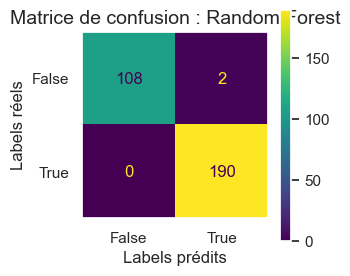

In [144]:
# 7. Visualisation - Matrice de confusion
plt.rcParams["figure.figsize"] = (3,3)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_rf_scaled, display_labels=['False','True'])
disp.plot()
plt.title('Matrice de confusion : Random Forest', size=14)
plt.ylabel('Labels réels', size=12)
plt.xlabel('Labels prédits', size=12)
plt.grid(None)

Interprétation : 
- TN (True Negatives) : 105 vrais négatifs
- FP (False Positives) : 5 négatifs mal classés comme positifs
- FN (False Negatives) : 0 positifs mal classés comme négatifs
- TP (True Positives) : 190 vrais positifs

In [146]:
# 8. Création d'une copie de X_test_scaled pour l'affichage des prédictions du test
df_test_rf = X_test.copy()

# 9. Ajout de la vraie cible et de la prédiction dans le dataframe de test
df_test_rf['cible (is_genuine)'] = y_test.values
df_test_rf['prediction'] = ['True' if p == 1 else 'False' for p in y_pred_scaled_rf]
df_test_rf

,diagonal,height_left,height_right,margin_low,margin_up,length,cible (is_genuine),prediction
1116,172.26,103.90,104.12,4.99000,3.42,111.27,False,False
1368,171.65,104.32,104.38,5.65000,3.24,112.30,False,False
422,171.53,103.53,103.63,4.04000,2.96,112.76,True,True
413,172.30,103.66,103.50,4.17914,3.16,112.95,True,True
451,172.17,103.79,103.54,4.07000,2.78,113.03,True,True
...,...,...,...,...,...,...,...,...
983,172.33,103.69,103.66,3.76000,3.09,113.66,True,True
799,172.50,104.03,103.79,4.27000,2.90,112.72,True,True
1265,172.37,104.54,104.03,5.82000,3.41,111.45,False,False
1150,171.79,104.86,104.34,5.39000,3.14,113.02,False,False


In [147]:
# 10. Ajout d'une colonne "correct" pour comparer les prédictions
df_test_rf['correct'] = df_test_rf['cible (is_genuine)'] == (y_pred_scaled_rf)
df_test_rf

,diagonal,height_left,height_right,margin_low,margin_up,length,cible (is_genuine),prediction,correct
1116,172.26,103.90,104.12,4.99000,3.42,111.27,False,False,True
1368,171.65,104.32,104.38,5.65000,3.24,112.30,False,False,True
422,171.53,103.53,103.63,4.04000,2.96,112.76,True,True,True
413,172.30,103.66,103.50,4.17914,3.16,112.95,True,True,True
451,172.17,103.79,103.54,4.07000,2.78,113.03,True,True,True
...,...,...,...,...,...,...,...,...,...
983,172.33,103.69,103.66,3.76000,3.09,113.66,True,True,True
799,172.50,104.03,103.79,4.27000,2.90,112.72,True,True,True
1265,172.37,104.54,104.03,5.82000,3.41,111.45,False,False,True
1150,171.79,104.86,104.34,5.39000,3.14,113.02,False,False,True


In [148]:
# 11. Affichage des faux billets prédits comme vrais (5 billets) - FP
rf_faux_classés_vrais = df_test_rf[(df_test_rf['cible (is_genuine)'] == False) & (df_test_rf['prediction'] == 'True')]
rf_faux_classés_vrais

,diagonal,height_left,height_right,margin_low,margin_up,length,cible (is_genuine),prediction,correct
1190,171.45,104.21,104.18,4.55,3.52,113.21,False,True,False
1452,171.93,104.15,103.98,4.57,3.57,112.71,False,True,False


In [149]:
# 12. Affichage des faux billets prédits comme faux (105 billets) - TN
rf_faux_classés_faux = df_test_rf[(df_test_rf['cible (is_genuine)'] == False) & (df_test_rf['prediction'] == 'False')]
rf_faux_classés_faux

,diagonal,height_left,height_right,margin_low,margin_up,length,cible (is_genuine),prediction,correct
1116,172.26,103.90,104.12,4.99,3.42,111.27,False,False,True
1368,171.65,104.32,104.38,5.65,3.24,112.30,False,False,True
1063,171.44,103.99,104.04,4.81,3.49,111.74,False,False,True
1272,171.73,103.74,104.38,5.14,3.16,111.73,False,False,True
1432,171.96,103.92,104.23,5.00,3.35,111.16,False,False,True
...,...,...,...,...,...,...,...,...,...
1404,171.76,103.79,104.05,5.12,3.22,112.08,False,False,True
1156,171.78,104.33,103.58,6.01,3.26,111.30,False,False,True
1276,172.47,104.27,104.10,4.88,3.33,110.68,False,False,True
1265,172.37,104.54,104.03,5.82,3.41,111.45,False,False,True


In [150]:
# 13. Affichage des vrais billets prédits comme faux (0 billets) - FN
rf_vrais_classés_faux = df_test_rf[(df_test_rf['cible (is_genuine)'] == True) & (df_test_rf['prediction']== 'False')]
rf_vrais_classés_faux

,diagonal,height_left,height_right,margin_low,margin_up,length,cible (is_genuine),prediction,correct


In [151]:
# 14. Affichage des vrais billets prédits comme vrais (190 billets) - TP
rf_vrais_classés_vrais = df_test_rf[(df_test_rf['cible (is_genuine)'] == True) & (df_test_rf['prediction'] == 'True')]
rf_vrais_classés_vrais

,diagonal,height_left,height_right,margin_low,margin_up,length,cible (is_genuine),prediction,correct
422,171.53,103.53,103.63,4.04000,2.96,112.76,True,True,True
413,172.30,103.66,103.50,4.17914,3.16,112.95,True,True,True
451,172.17,103.79,103.54,4.07000,2.78,113.03,True,True,True
861,171.86,104.21,103.74,4.43000,2.90,113.65,True,True,True
741,172.17,103.75,103.29,4.43000,2.88,113.38,True,True,True
...,...,...,...,...,...,...,...,...,...
111,172.03,103.96,103.58,4.06000,2.85,113.02,True,True,True
780,172.41,103.95,103.79,4.09755,3.13,113.41,True,True,True
983,172.33,103.69,103.66,3.76000,3.09,113.66,True,True,True
799,172.50,104.03,103.79,4.27000,2.90,112.72,True,True,True


2/ SUR DONNEES NON STANDARDISEES :

In [153]:
# 1. Pour rappel : Séparation des variables d’entrée et variable cible
   # X = Variables d'entrée (toutes les colonnes de dimensions)
   # Y = Variable cible (vrai ou faux billet)

# 2. Séparation entraînement (80%) / test (20%)
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

In [154]:
# 3. Application du modèle RANDOM FOREST
rf= RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

In [155]:
# 4. Score (évaluation des performances)
print("Accuracy score du modèle Random Forest :", accuracy_score(y_test, y_pred_rf))
print("% d'erreur du modèle Random Forest :", round(1-accuracy_score(y_test, y_pred_rf),2))

Accuracy score du modèle Random Forest : 0.99
% d'erreur du modèle Random Forest : 0.01


Interprétation : Cela signifie que 99 % des billets sont bien classés (vrais/faux) et que le pourcentage d'erreur est de 1%.

In [157]:
# 5. Matrice de confusion
cm_rf = confusion_matrix(y_test, y_pred_rf)
print('Matrice de confusion :')
print(cm_rf)

Matrice de confusion :
[[107   3]
 [  0 190]]


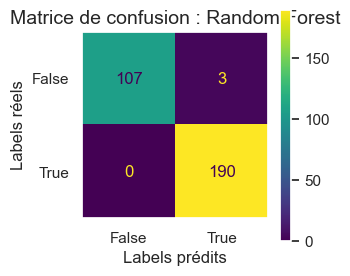

In [158]:
# 6. Visualisation - Matrice de confusion
plt.rcParams["figure.figsize"] = (3,3)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_rf, display_labels=['False','True'])
disp.plot()
plt.title('Matrice de confusion : Random Forest', size=14)
plt.ylabel('Labels réels', size=12)
plt.xlabel('Labels prédits', size=12)
plt.grid(None)

Interprétation : 
- TN (True Negatives) : 107 vrais négatifs
- FP (False Positives) : 3 négatifs mal classés comme positifs
- FN (False Negatives) : 0 positifs mal classés comme négatifs
- TP (True Positives) : 190 vrais positifs

<div style="background-color: RGB(51,165,182);" >
<h2 style="margin: auto; padding: 20px; color:#fff; ">Etape 6 - Synthèse des 4 modèles de prédiction</h2>
</div>

Synthèse par modèle de prédiction : 
- K-Means : 99% 'accuracy score / 1% d'erreur (données standardisées)
- Régression logistique : 99% 'accuracy score / 1% d'erreur
- KNN : 98% 'accuracy score / 2% d'erreur
- Random Forest : 98% 'accuracy score / 2% d'erreur (données standardisées) versus 99% 'accuracy score / 1% d'erreur (données non standardisées)

Les modèles les plus fiables sont les modèles de prédiction par la régression logistique et par K-Means. Or K-Means est un modèle non supervisé contrairement à la régression logistique (dans notre cas un modèle non supervisé est inadapté), nous retiendrons uniquement la régression logistique pour le test des prédictions qui va avoir lieu après.

<div style="background-color: RGB(51,165,182);" >
<h2 style="margin: auto; padding: 20px; color:#fff; ">Etape 7 - Test de la prédiction (avec un autre échantillon)</h2>
</div>

In [164]:
# Import du dataframe à tester pour la prédiction de billets (vrai/faux)
df_prod = pd.read_csv('billets_production.csv', sep=',')
df_prod.head()

,diagonal,height_left,height_right,margin_low,margin_up,length,id
0,171.76,104.01,103.54,5.21,3.30,111.42,A_1
1,171.87,104.17,104.13,6.00,3.31,112.09,A_2
2,172.00,104.58,104.29,4.99,3.39,111.57,A_3
3,172.49,104.55,104.34,4.44,3.03,113.20,A_4
4,171.65,103.63,103.56,3.77,3.16,113.33,A_5


In [165]:
# Vérification des typologies des variables
df_prod.dtypes

diagonal        float64
height_left     float64
height_right    float64
margin_low      float64
margin_up       float64
length          float64
id               object
dtype: object

In [166]:
# Affichage des caractéristiques des données
df_prod.describe()

,diagonal,height_left,height_right,margin_low,margin_up,length
count,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000
mean,171.954000,104.188000,103.972000,4.882000,3.238000,112.322000
std,0.326542,0.396257,0.393027,0.836821,0.142724,0.897201
min,171.650000,103.630000,103.540000,3.770000,3.030000,111.420000
25%,171.760000,104.010000,103.560000,4.440000,3.160000,111.570000
50%,171.870000,104.170000,104.130000,4.990000,3.300000,112.090000
75%,172.000000,104.550000,104.290000,5.210000,3.310000,113.200000
max,172.490000,104.580000,104.340000,6.000000,3.390000,113.330000


In [167]:
# Recherche de données manquantes (nombres de cellules vides)
df_prod.isnull().sum()

diagonal        0
height_left     0
height_right    0
margin_low      0
margin_up       0
length          0
id              0
dtype: int64

In [168]:
# Suppression de la colonne d'ID
df_prod_clean = df_prod.drop(columns=['id']) 

In [169]:
# Normalisation des données (application du même scaler que celui utilisé sur X_train)
df_prod_clean_scaled = scaler.transform(df_prod_clean)

In [170]:
# Prédictions avec probabilités
prod_probabilities = logisticReg1.predict_proba(df_prod_clean_scaled)[:, 1]     # Probabilité classe 1 (=soit un vrai billet)
prod_predictions = np.where(prod_probabilities >= 0.5, 'True', 'False')         # Arrondi prédictions binaires (0 ou 1) pour col. 'type_prediction' : seuil à 0.5

# DataFrame résultat avec les prédictions binaires
df_prod_predictions = pd.DataFrame(prod_predictions, columns=['type_prediction'], index=df_prod_clean.index)
df_prod_predictions

,type_prediction
0,False
1,False
2,False
3,True
4,True


In [171]:
# DataFrame résultat avec les probabilités (taux de prédiction par billet)
df_prod_probabilities = pd.DataFrame(prod_probabilities, columns=['taux_prediction'], index=df_prod_clean.index)
df_prod_probabilities['taux_prediction'] = round(df_prod_probabilities['taux_prediction'] * 100, 2)
df_prod_probabilities

,taux_prediction
0,0.21
1,0.03
2,0.04
3,96.96
4,99.98


In [172]:
# DataFrame final de résultats avec les probabilités et prédictions
df_prod_final = pd.concat([df_prod_clean, df_prod_predictions, df_prod_probabilities], axis=1)
df_prod_final

,diagonal,height_left,height_right,margin_low,margin_up,length,type_prediction,taux_prediction
0,171.76,104.01,103.54,5.21,3.30,111.42,False,0.21
1,171.87,104.17,104.13,6.00,3.31,112.09,False,0.03
2,172.00,104.58,104.29,4.99,3.39,111.57,False,0.04
3,172.49,104.55,104.34,4.44,3.03,113.20,True,96.96
4,171.65,103.63,103.56,3.77,3.16,113.33,True,99.98


Interprétation : 
- Index 0 : Le modèle estime à 5.85% la probabilité que ce billet soit vrai => FAUX BILLET
- Index 1 : Le modèle estime à 1.83% la probabilité que ce billet soit vrai => FAUX BILLET
- Index 2 : Le modèle estime à 0.96% la probabilité que ce billet soit vrai => FAUX BILLET
- Index 3 : Le modèle estime à 0.99% la probabilité que ce billet soit vrai => VRAI BILLET
- Index 4 :  Le modèle estime à 0.99% la probabilité que ce billet soit vrai => VRAI BILLET

In [174]:
# Fonction d'automatisation du test de prédiction sur un fichier CSV contenant des billets à prédire

def auto_test_prediction(path_csv, model, scaler, seuil=0.5):

    # 1. Chargement des données à tester
    df_prod = pd.read_csv(path_csv, sep=',')
    print("Chargement des données :")
    
    # 2. Vérifications basiques
    print("\nTypes des variables :\n", df_prod.dtypes)
    print("\nStatistiques descriptives :\n", df_prod.describe())
    print("\nValeurs manquantes :\n", df_prod.isnull().sum())

    # 3. Suppression de la colonne "ID"
    if 'id' in df_prod.columns:
        df_prod_clean = df_prod.drop(columns=['id'])
    else:
        df_prod_clean = df_prod.copy()

    # 4. Normalisation des données avec le scaler déjà entraîné
    df_prod_clean_scaled = scaler.transform(df_prod_clean)

    # 5. Prédictions : probabilités + types
    probabilities = model.predict_proba(df_prod_clean_scaled)[:, 1]
    predictions = np.where(probabilities >= seuil, 'True', 'False')

    # 6. DataFrame final de résultats avec les probabilités et prédictions
    df_prod_final = df_prod_clean.copy()
    df_prod_final['type_prediction'] = predictions
    df_prod_final['taux_prediction'] = np.round(probabilities * 100, 2)

    print("\n Résultat des prédictions : ")
    return df_prod_final

In [175]:
# Appel de la fonction "auto_test_prediction"

# Nom du fichier de données à modifier lors de la soutenance

df_prod_final = auto_test_prediction('billets_test (1).csv', model=logisticReg1, scaler=scaler, seuil=0.5)
df_prod_final.head(50)

Chargement des données :

Types des variables :
 diagonal        float64
height_left     float64
height_right    float64
margin_low      float64
margin_up       float64
length          float64
id               object
dtype: object

Statistiques descriptives :
          diagonal  height_left  height_right  margin_low  margin_up     length
count    5.000000     5.000000      5.000000    5.000000   5.000000    5.00000
mean   171.840000   104.068000    103.974000    4.808000   3.172000  112.27400
std      0.225499     0.206325      0.259769    0.707404   0.097826    0.97879
min    171.520000   103.800000    103.730000    3.810000   3.070000  111.10000
25%    171.780000   103.950000    103.750000    4.390000   3.090000  111.82000
50%    171.790000   104.080000    103.990000    5.000000   3.160000  111.87000
75%    172.020000   104.170000    104.030000    5.270000   3.240000  113.19000
max    172.090000   104.340000    104.370000    5.570000   3.300000  113.39000

Valeurs manquantes :
 diago

,diagonal,height_left,height_right,margin_low,margin_up,length,type_prediction,taux_prediction
0,172.09,103.95,103.73,4.39,3.09,113.19,True,99.53
1,171.52,104.17,104.03,5.27,3.16,111.82,False,0.56
2,171.78,103.80,103.75,3.81,3.24,113.39,True,99.95
3,172.02,104.08,103.99,5.57,3.30,111.10,False,0.01
4,171.79,104.34,104.37,5.00,3.07,111.87,False,1.42
